In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TRAIN_START_DATE = '2009-06-11'
TRAIN_END_DATE = '2021-12-31'


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

TRAINED_PPO = "/model_checkpoint_2000000_steps_softmax"

GRAPH_TITLE = "PPO Trained 2009-2021, Two Million Time Steps Checkpoint"


# Backtest the results


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader



df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (18972, 8)


In [2]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.27901337 0.2993547  0.28694895 ... 0.0420757  0.03314671 0.03177728]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.75 1.   0.   ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2009-06-11,0.027517,0.027759,0.027716,0.023764,0.279013,AAPL,0.75
1,2009-06-11,0.116208,0.117867,0.114678,0.090075,0.114834,BA,0.75
2,2009-06-11,0.241789,0.241016,0.242163,0.168001,0.267440,INTC,0.75
3,2009-06-11,0.065550,0.066520,0.065956,0.050880,0.203949,MSFT,0.75
4,2009-06-11,0.069336,0.068865,0.067138,0.061081,0.130206,V,0.75
...,...,...,...,...,...,...,...,...
18967,2021-12-30,0.455147,0.461873,0.460256,0.471090,0.067943,BA,0.75
18968,2021-12-30,0.761290,0.752490,0.767345,0.772947,0.092257,INTC,0.75
18969,2021-12-30,0.992136,0.981297,0.990123,0.988954,0.050090,MSFT,0.75
18970,2021-12-30,0.871706,0.867337,0.874829,0.870964,0.011296,V,0.75


# PPO On portfolio Opt

In [3]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization_ppo import PortfolioOptimizationPPOEnv

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime



environment_ppo = PortfolioOptimizationPPOEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [4]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
# trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_10_27") 


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 

In [5]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "train": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo)
PPO_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["train"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["train"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["train"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


print(df_ppo_opt.loc[0, 'Date'])


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\env_portfolio_optimization\env_portfolio_optimization_ppo.py:310: RuntimeWarning: invalid value encountered in divide
  weights = actions / action_sum
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\env_portfolio_optimization\env_portfolio_optimization_ppo.py:310: RuntimeWarning: invalid value encountered in divide
  weights = actions / action_sum
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\env_portfolio_optimization\env_portfolio_optimization_ppo.py:310: RuntimeWarning: invalid value encountered in divid

Initial portfolio value:1000000
Final portfolio value: 3405709.7575457958
Final accumulative portfolio value: 3.4057097575457957
Maximum DrawDown: -0.18597268918706866
Sharpe ratio: 0.7900604722090234
hit end!
      ppo_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          1.000000e+06 2009-06-12
2          1.000000e+06 2009-06-15
3          1.000000e+06 2009-06-16
4          1.000000e+06 2009-06-17
...                 ...        ...
3157       3.405710e+06 2021-12-23
3158       3.405710e+06 2021-12-27
3159       3.405710e+06 2021-12-28
3160       3.405710e+06 2021-12-29
3161       3.405710e+06 2021-12-30

[3162 rows x 2 columns]
2009-06-11 00:00:00


In [6]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2009-06-11 00:00:00')

# Porfolio Baselines

In [7]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment_benchmark = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


In [8]:
# CRP 

CRP_results = {
    "train": {},
}

environment_benchmark.reset()
agent_crp = DRLStableAgent(env = environment_benchmark)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmark)
CRP_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
CRP_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["train"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["train"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 12435210.0
Final accumulative portfolio value: 12.43521
Maximum DrawDown: -0.35611465369647677
Sharpe ratio: 1.134345526873852
Total commission cost: 125359.03514880047
hit end!
      crp_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          9.981216e+05 2009-06-12
2          9.836768e+05 2009-06-15
3          9.749473e+05 2009-06-16
4          9.757082e+05 2009-06-17
...                 ...        ...
3157       1.231608e+07 2021-12-23
3158       1.245368e+07 2021-12-27
3159       1.249117e+07 2021-12-28
3160       1.247438e+07 2021-12-29
3161       1.243521e+07 2021-12-30

[3162 rows x 2 columns]


In [9]:
# BAH

BAH_results = {
    "train": {},
}

environment_benchmark.reset()
agent_bah = DRLStableAgent(env = environment_benchmark)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmark)
BAH_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BAH_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["train"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["train"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 14832426.0
Final accumulative portfolio value: 14.832426
Maximum DrawDown: -0.35023130722902607
Sharpe ratio: 1.1684801831363556
Total commission cost: 125359.03514880047
hit end!
      bah_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          9.981216e+05 2009-06-12
2          9.835615e+05 2009-06-15
3          9.749660e+05 2009-06-16
4          9.759362e+05 2009-06-17
...                 ...        ...
3157       1.468340e+07 2021-12-23
3158       1.493658e+07 2021-12-27
3159       1.490845e+07 2021-12-28
3160       1.491004e+07 2021-12-29
3161       1.483243e+07 2021-12-30

[3162 rows x 2 columns]


In [10]:
# OLMAR

OLMAR_results = {
    "train": {},
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 100
}



environment_benchmark.reset()
agent_olmar = DRLStableAgent(env = environment_benchmark)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmark)
OLMAR_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
OLMAR_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["train"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["train"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 4850056.0
Final accumulative portfolio value: 4.850056
Maximum DrawDown: -0.73577120658556
Sharpe ratio: 0.5430288111259708
Total commission cost: 2174629.449518655
hit end!
      olmar_opt_net_worth       Date
0            1.000000e+06 2009-06-11
1            9.981216e+05 2009-06-12
2            1.000310e+06 2009-06-15
3            1.001592e+06 2009-06-16
4            1.011416e+06 2009-06-17
...                   ...        ...
3157         4.886184e+06 2021-12-23
3158         4.861062e+06 2021-12-27
3159         4.931883e+06 2021-12-28
3160         4.872786e+06 2021-12-29
3161         4.850056e+06 2021-12-30

[3162 rows x 2 columns]


In [11]:
# RMR 

RMR_results = {
    "train": {},
}

RMR_model_kwargs = {
    "eps": 60,
    "window": 100
}

environment_benchmark.reset()
agent_rmr = DRLStableAgent(env = environment_benchmark)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=RMR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmark)
RMR_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
RMR_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["train"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["train"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 35849508.0
Final accumulative portfolio value: 35.849508
Maximum DrawDown: -0.4379715426822355
Sharpe ratio: 1.1603464249534474
Total commission cost: 2197825.852806352
hit end!
      rmr_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          9.981216e+05 2009-06-12
2          1.000310e+06 2009-06-15
3          1.001592e+06 2009-06-16
4          1.011416e+06 2009-06-17
...                 ...        ...
3157       3.546324e+07 2021-12-23
3158       3.627801e+07 2021-12-27
3159       3.606879e+07 2021-12-28
3160       3.608689e+07 2021-12-29
3161       3.584951e+07 2021-12-30

[3162 rows x 2 columns]


In [12]:
# BNN

BNN_results = {
    "train": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmark.reset()
agent_bnn = DRLStableAgent(env = environment_benchmark)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmark)
BNN_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BNN_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["train"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["train"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 28512766.0
Final accumulative portfolio value: 28.512766
Maximum DrawDown: -0.43797181814388786
Sharpe ratio: 1.0962606525392273
Total commission cost: 2279796.675800269
hit end!
      bnn_opt_net_worth       Date
0             1000000.0 2009-06-11
1             1000000.0 2009-06-12
2             1000000.0 2009-06-15
3             1000000.0 2009-06-16
4             1000000.0 2009-06-17
...                 ...        ...
3157         28205552.0 2021-12-23
3158         28853570.0 2021-12-27
3159         28687168.0 2021-12-28
3160         28701566.0 2021-12-29
3161         28512766.0 2021-12-30

[3162 rows x 2 columns]


In [13]:
# SCRP


SCRP_results = {
    "train": {},
}


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": None
}

environment_benchmark.reset()
agent_scrp = DRLStableAgent(env = environment_benchmark)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmark)
SCRP_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
SCRP_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["train"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["train"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 31381060.0
Final accumulative portfolio value: 31.38106
Maximum DrawDown: -0.43797174981579423
Sharpe ratio: 1.1211728331650375
Total commission cost: 2285417.716078846
hit end!
      scrp_opt_net_worth       Date
0           1.000000e+06 2009-06-11
1           9.981216e+05 2009-06-12
2           1.000310e+06 2009-06-15
3           1.001592e+06 2009-06-16
4           1.011416e+06 2009-06-17
...                  ...        ...
3157        3.104294e+07 2021-12-23
3158        3.175615e+07 2021-12-27
3159        3.157301e+07 2021-12-28
3160        3.158885e+07 2021-12-29
3161        3.138106e+07 2021-12-30

[3162 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [14]:
# bcrp

BCRP_results = {
    "train": {},
}

environment_benchmark.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmark)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmark)
BCRP_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BCRP_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["train"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["train"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 41584092.0
Final accumulative portfolio value: 41.584092
Maximum DrawDown: -0.43797157811344645
Sharpe ratio: 1.2041043044189998
Total commission cost: 2285417.716285028
hit end!
      bcrp_opt_net_worth       Date
0           1.000000e+06 2009-06-11
1           9.787069e+05 2009-06-12
2           9.724186e+05 2009-06-15
3           9.742761e+05 2009-06-16
4           9.687746e+05 2009-06-17
...                  ...        ...
3157        4.113604e+07 2021-12-23
3158        4.208114e+07 2021-12-27
3159        4.183845e+07 2021-12-28
3160        4.185944e+07 2021-12-29
3161        4.158409e+07 2021-12-30

[3162 rows x 2 columns]


# Stock environment optimization algorithm

In [15]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [16]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_ppo_date.loc[0,'Date'],
        end = df_ppo_date.loc[len(df_ppo_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_ppo_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3161, 8)
Annual return          0.120358
Cumulative returns     3.160183
Annual volatility      0.169843
Sharpe ratio           0.754808
Calmar ratio           0.324535
Stability              0.971076
Max drawdown          -0.370862
Omega ratio            1.160527
Sortino ratio          1.053373
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.945741
Daily value at risk   -0.020889
dtype: float64
df_dji:             date           dji
0    2009-06-11  1.000000e+06
1    2009-06-12  1.003231e+06
2    2009-06-15  9.818959e+05
3    2009-06-16  9.696440e+05
4    2009-06-17  9.687900e+05
...         ...           ...
3157 2021-12-23  4.098836e+06
3158 2021-12-27  4.138948e+06
3159 2021-12-28  4.149874e+06
3160 2021-12-29  4.160183e+06
3161 2021-12-30           NaN

[3162 rows x 2 columns]
df_dji:                       dji
date                    
2009-06-11  1.000000e+06
2009-06-12  1.003231e+06
2009-06-15  9.818959e+05
2009-06-16

# Compare all results

In [17]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')
# olmar = pd.read_csv('OLMAR_net_worth.csv')



# merged_df = olmar
# merged_df = pd.merge(merged_df, olmar, on='Date')

# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')


print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2009-06-11  1.000000e+06
2009-06-12  1.003231e+06
2009-06-15  9.818959e+05
2009-06-16  9.696440e+05
2009-06-17  9.687900e+05
...                  ...
2021-12-23  4.098836e+06
2021-12-27  4.138948e+06
2021-12-28  4.149874e+06
2021-12-29  4.160183e+06
2021-12-30           NaN

[3162 rows x 1 columns]
      crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1.000000e+06 2009-06-11        1.000000e+06       1.000000e+06   
1          9.981216e+05 2009-06-12        9.787069e+05       9.981216e+05   
2          9.836768e+05 2009-06-15        9.724186e+05       9.835615e+05   
3          9.749473e+05 2009-06-16        9.742761e+05       9.749660e+05   
4          9.757082e+05 2009-06-17        9.687746e+05       9.759362e+05   
...                 ...        ...                 ...                ...   
3157       1.231608e+07 2021-12-23        4.113604e+07       1.468340e+07   
3158       1.245368e+07 2021-12-27

# Baseline CRP in the environment

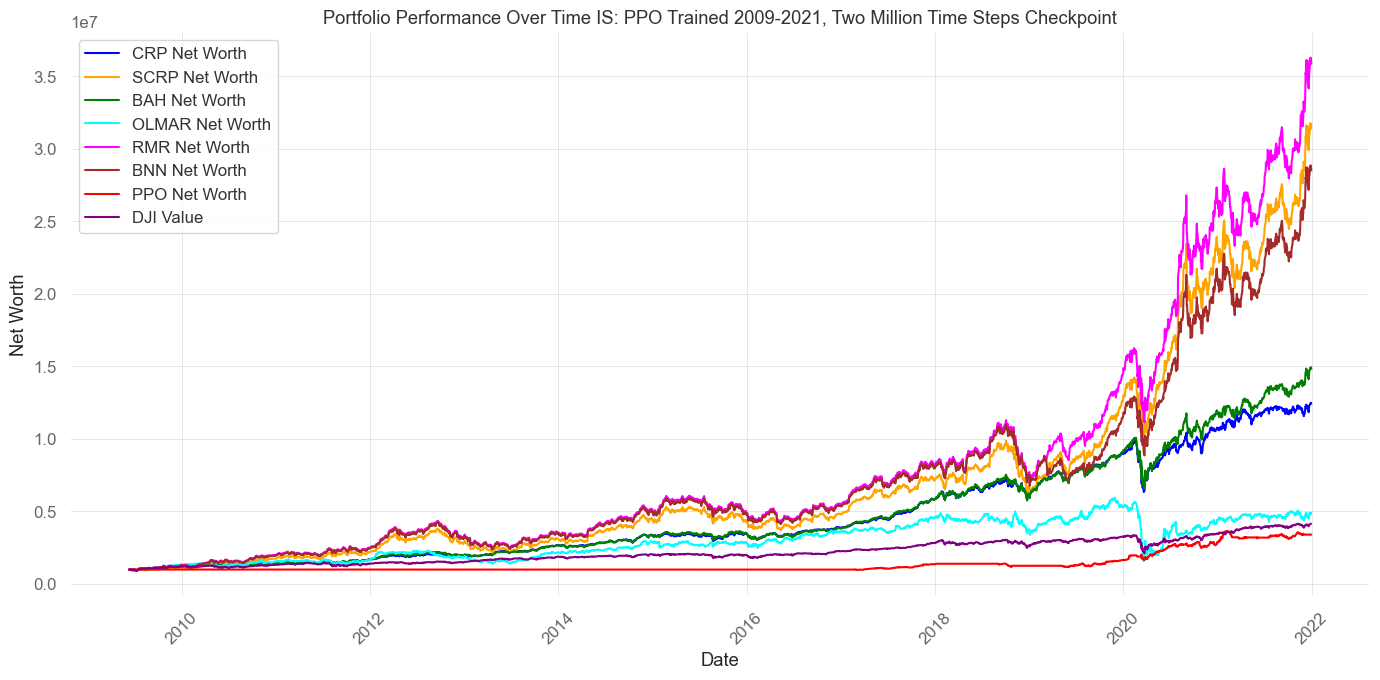

In [18]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'PPO Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}

plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Net Worth', color=color_map['PPO Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time IS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Final returns

import pprint

final_returns = {
   'BCRP': merged_df['bcrp_opt_net_worth'].iloc[-1],
   'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
   'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
   'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
   'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
   'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
   'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 14832426.0,
 'BCRP': 41584092.0,
 'BNN': 28512766.0,
 'CRP': 12435210.0,
 'OLMAR': 4850056.0,
 'PPO': 3405709.7575457958,
 'RMR': 35849508.0,
 'SCRP': 31381060.0}


In [20]:
import numpy as np

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()
# merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
# merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),
    # 'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    # 'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

pprint.pprint(sharpe_ratios)

{'BAH': 1.0693925505911628,
 'BCRP': 1.1326962761870016,
 'BNN': 1.0248421210625962,
 'CRP': 1.0313275513817322,
 'OLMAR': 0.48381318867293555,
 'PPO': 0.6422636168987823,
 'RMR': 1.0890409801531593,
 'SCRP': 1.0499680373097073}


In [21]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'PPO': max_drawdown(merged_df['ppo_value']),
    # 'TD3': max_drawdown(merged_df['td3_value'])
}

pprint.pprint(max_drawdowns)


{'BAH': -0.35023130722902607,
 'BCRP': -0.43797157811344645,
 'BNN': -0.43797181814388786,
 'CRP': -0.35611465369647677,
 'OLMAR': -0.73577120658556,
 'PPO': -0.18597268918706866,
 'RMR': -0.4379715426822355,
 'SCRP': -0.43797174981579423}


In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'CRP_opt_daily_return', 'BCRP_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq       df         F    PR(>F)
Portfolio  0.001319      3.0  2.541193  0.054515
Residual   2.187595  12640.0       NaN       NaN
